In [737]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, accuracy_score

from interpret.glassbox import ExplainableBoostingClassifier

import seaborn as sns
import shap

# Data analysis

In [738]:
seed = 42

torch.backends.cudnn.deterministic = True
torch.manual_seed(seed)
cuda = torch.cuda.is_available()
if cuda is True:
	torch.cuda.manual_seed(seed)
	torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

In [739]:
path = "data/credit_card_churn.csv"

In [740]:
df = pd.read_csv(path)

In [741]:
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [742]:
print("null: \n", df.isna().sum())


null: 
 CLIENTNUM                                                                                                                             0
Attrition_Flag                                                                                                                        0
Customer_Age                                                                                                                          0
Gender                                                                                                                                0
Dependent_count                                                                                                                       0
Education_Level                                                                                                                       0
Marital_Status                                                                                                                        0
Income_Category                         

In [743]:
print("duplicates: ", df.duplicated(keep=False).sum())
print("imbalance count: \n", df['Attrition_Flag'].value_counts())
print("\nimbalance ratio:\n", df['Attrition_Flag'].value_counts(normalize=True))
print(len(df.columns))

duplicates:  0
imbalance count: 
 Attrition_Flag
Existing Customer    8500
Attrited Customer    1627
Name: count, dtype: int64

imbalance ratio:
 Attrition_Flag
Existing Customer    0.83934
Attrited Customer    0.16066
Name: proportion, dtype: float64
23


# Preprocessing

In [744]:
df.drop(["Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1",
		"Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2", 
		"CLIENTNUM"],
		axis=1, inplace=True)

In [745]:
df["Attrition_Flag"].unique()

array(['Existing Customer', 'Attrited Customer'], dtype=object)

In [746]:
df['Attrition_Flag'] = df['Attrition_Flag'].map({'Existing Customer': 0, 'Attrited Customer': 1})

In [747]:
y = df['Attrition_Flag']
x = df.drop(columns=["Attrition_Flag"])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed, stratify=y, shuffle=True)

In [748]:
cat_cols = ["Gender", "Marital_Status"]
ordinal_cols = ["Education_Level", "Card_Category", "Income_Category"]
num_cols = ["Customer_Age", "Dependent_count", "Months_on_book", "Total_Relationship_Count", "Months_Inactive_12_mon", "Contacts_Count_12_mon", "Credit_Limit", "Total_Revolving_Bal", "Avg_Open_To_Buy", "Total_Amt_Chng_Q4_Q1", "Total_Trans_Amt", "Total_Trans_Ct", "Total_Ct_Chng_Q4_Q1", "Avg_Utilization_Ratio"]

In [749]:
ohe = OneHotEncoder(handle_unknown='ignore')

ohe.fit(x_train[cat_cols])

#Apply on train data
x_train_enc1 = pd.DataFrame(data=ohe.transform(x_train[cat_cols]).toarray(), 
							columns=ohe.get_feature_names_out())

x_train_enc = x_train.copy()

x_train_enc.drop(columns=cat_cols, axis=1, inplace=True)
x_train_enc = pd.concat([x_train_enc.reset_index(drop=True), x_train_enc1], axis=1)

#repeat on test data
x_test_enc1 = pd.DataFrame(data=ohe.transform(x_test[cat_cols]).toarray(),
							columns=ohe.get_feature_names_out())

x_test_enc = x_test.copy()

x_test_enc.drop(columns=cat_cols, axis=1, inplace=True)
x_test_enc = pd.concat([x_test_enc.reset_index(drop=True), x_test_enc1], axis=1)


In [750]:
x_train_enc.head()

,Customer_Age,Dependent_count,Education_Level,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,...,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_F,Gender_M,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown
0,36,0,Unknown,Less than $40K,Blue,24,4,3,2,2570.0,...,1755,42,0.448,0.868,1.0,0.0,0.0,1.0,0.0,0.0
1,44,3,High School,$60K - $80K,Silver,36,5,2,3,25276.0,...,2282,38,0.583,0.000,0.0,1.0,0.0,0.0,1.0,0.0
2,46,2,High School,$80K - $120K,Blue,30,6,3,1,11670.0,...,4277,89,0.854,0.078,0.0,1.0,0.0,1.0,0.0,0.0
3,36,2,Graduate,Less than $40K,Blue,24,3,1,3,3124.0,...,1652,41,0.367,0.510,1.0,0.0,0.0,1.0,0.0,0.0
4,50,1,Graduate,$120K +,Blue,40,4,2,3,34516.0,...,3874,72,0.714,0.034,0.0,1.0,0.0,0.0,1.0,0.0


In [751]:
edu_level_enc_order = [
	'Unknown', 
	'Uneducated',	
	'High School',
	'Graduate',
	'College',
	'Doctorate',
	'Post-Graduate'
]

card_cat_order = ["Blue", "Silver", "Gold", "Platinum"]

income_cat_order = [
	'Unknown', 
	'Less than $40K',
	'$40K - $60K',
	'$60K - $80K',
	'$80K - $120K',
	'$120K +',
 ]

In [752]:
#Ordinal encoder on Education 

categories = {
	"Education_Level": edu_level_enc_order,
	"Card_Category": card_cat_order,
	"Income_Category": income_cat_order
}

for cat in ordinal_cols:
	category = categories[cat]

	ord_enc = OrdinalEncoder(categories=[category])
	new_cat_string = f'{cat}_enc'
	x_train_enc[new_cat_string] = ord_enc.fit_transform(x_train_enc.loc[:, [cat]])
	x_test_enc[new_cat_string] = ord_enc.transform(x_test_enc.loc[:, [cat]])

x_train_enc.drop(columns=ordinal_cols, axis=1, inplace=True)
x_test_enc.drop(columns=ordinal_cols, axis=1, inplace=True)


In [753]:
# Drop features that have reduntant information based on other features
x_train_enc.drop(columns=["Marital_Status_Unknown", "Gender_M"], inplace=True)
x_test_enc.drop(columns=["Marital_Status_Unknown", "Gender_M"], inplace=True)

In [754]:
# scaler = StandardScaler()
# scaler.fit(x_train_enc[num_cols])
# x_train_enc[num_cols] = scaler.transform(x_train_enc[num_cols])
# x_test_enc[num_cols] = scaler.transform(x_test_enc[num_cols])

In [755]:
# Correlation matrix
corr_data = x_train_enc.copy()
corr_data["y"] = y_train
correlation_matrix = corr_data.corr()
print(correlation_matrix)

                          Customer_Age  Dependent_count  Months_on_book  \
Customer_Age                  1.000000        -0.128513        0.788514   
Dependent_count              -0.128513         1.000000       -0.110090   
Months_on_book                0.788514        -0.110090        1.000000   
Total_Relationship_Count     -0.012365        -0.029654       -0.006560   
Months_Inactive_12_mon        0.050519        -0.011870        0.067783   
Contacts_Count_12_mon        -0.030583        -0.036238       -0.024270   
Credit_Limit                  0.000805         0.074767        0.005345   
Total_Revolving_Bal           0.021949        -0.010639        0.008759   
Avg_Open_To_Buy              -0.001175         0.075727        0.004555   
Total_Amt_Chng_Q4_Q1         -0.054357        -0.038578       -0.041154   
Total_Trans_Amt              -0.046256         0.027159       -0.038407   
Total_Trans_Ct               -0.066422         0.054138       -0.048773   
Total_Ct_Chng_Q4_Q1      

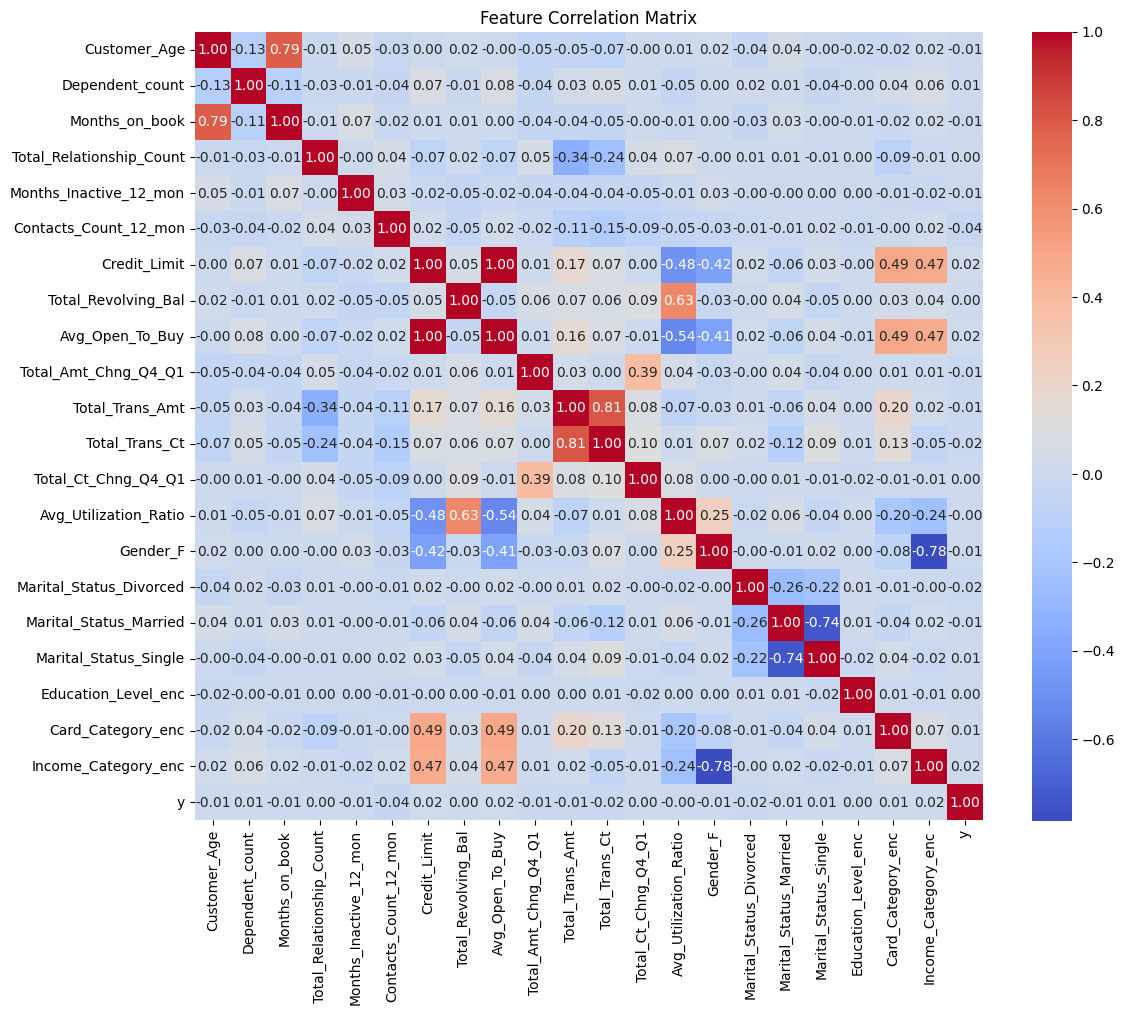

In [756]:
# Compute correlation matrix
correlation_matrix = corr_data.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

In [757]:
x_train_enc.drop(columns=["Avg_Open_To_Buy", "Customer_Age", "Total_Trans_Ct", "Avg_Utilization_Ratio"], inplace=True)
x_test_enc.drop(columns=["Avg_Open_To_Buy", "Customer_Age", "Total_Trans_Ct", "Avg_Utilization_Ratio"], inplace=True)

In [758]:
pipe = Pipeline([
	("rf", RandomForestClassifier(class_weight="balanced", random_state=seed, max_depth=8))
])

In [759]:
pipe.fit(x_train_enc, y_train)
y_pred = pipe.predict(x_test_enc)

In [760]:
print(f"Train accuracy: {pipe.score(x_train_enc, y_train)}")
print(f"Test accuracy: {pipe.score(x_test_enc, y_test)}")

report = classification_report(y_true=y_test, y_pred=y_pred)
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
print(report)

Train accuracy: 0.9585236390569065
Test accuracy: 0.9313919052319842
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1701
           1       0.77      0.82      0.79       325

    accuracy                           0.93      2026
   macro avg       0.87      0.89      0.88      2026
weighted avg       0.93      0.93      0.93      2026



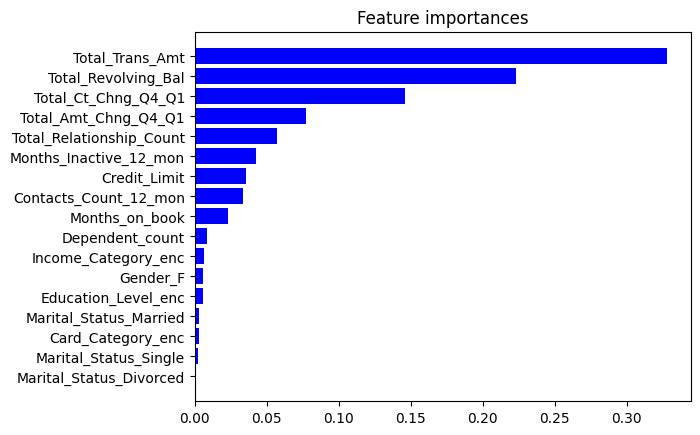

In [761]:
feature_importance = pipe["rf"].feature_importances_
feature_names = x_train_enc.columns

sorted_idx = feature_importance.argsort()

#Plot the feature importance
plt.barh(feature_names[sorted_idx], feature_importance[sorted_idx], color='blue')
plt.title("Feature importances")
# plt.savefig("pictures/feat_imp1_depth_5.png")  # high quality
plt.show()

In [762]:
perm_imp_train = permutation_importance(pipe, x_train_enc, y_train, n_repeats=10, random_state=seed)

for i, feature in enumerate(x_train_enc.columns):
  print(f"- {feature} => Mean: {perm_imp_train.importances_mean[i]:.4f} ; Std: {perm_imp_train.importances_std[i]:.4f}")

- Dependent_count => Mean: 0.0038 ; Std: 0.0004
- Months_on_book => Mean: 0.0078 ; Std: 0.0005
- Total_Relationship_Count => Mean: 0.0386 ; Std: 0.0022
- Months_Inactive_12_mon => Mean: 0.0122 ; Std: 0.0012
- Contacts_Count_12_mon => Mean: 0.0042 ; Std: 0.0010
- Credit_Limit => Mean: 0.0115 ; Std: 0.0008
- Total_Revolving_Bal => Mean: 0.0518 ; Std: 0.0014
- Total_Amt_Chng_Q4_Q1 => Mean: 0.0167 ; Std: 0.0012
- Total_Trans_Amt => Mean: 0.1532 ; Std: 0.0032
- Total_Ct_Chng_Q4_Q1 => Mean: 0.0195 ; Std: 0.0012
- Gender_F => Mean: 0.0028 ; Std: 0.0007
- Marital_Status_Divorced => Mean: 0.0001 ; Std: 0.0001
- Marital_Status_Married => Mean: 0.0011 ; Std: 0.0003
- Marital_Status_Single => Mean: 0.0010 ; Std: 0.0003
- Education_Level_enc => Mean: 0.0013 ; Std: 0.0003
- Card_Category_enc => Mean: 0.0008 ; Std: 0.0001
- Income_Category_enc => Mean: 0.0015 ; Std: 0.0004


In [763]:
perm_imp_test = permutation_importance(pipe, x_test_enc, y_test, n_repeats=10, random_state=seed)

for i, feature in enumerate(x_test_enc.columns):
  print(f"- {feature} => Mean: {perm_imp_test.importances_mean[i]:.4f} ; Std: {perm_imp_test.importances_std[i]:.4f}")

- Dependent_count => Mean: 0.0022 ; Std: 0.0012
- Months_on_book => Mean: 0.0070 ; Std: 0.0012
- Total_Relationship_Count => Mean: 0.0333 ; Std: 0.0032
- Months_Inactive_12_mon => Mean: 0.0115 ; Std: 0.0032
- Contacts_Count_12_mon => Mean: 0.0055 ; Std: 0.0025
- Credit_Limit => Mean: 0.0090 ; Std: 0.0021
- Total_Revolving_Bal => Mean: 0.0440 ; Std: 0.0044
- Total_Amt_Chng_Q4_Q1 => Mean: 0.0123 ; Std: 0.0036
- Total_Trans_Amt => Mean: 0.1428 ; Std: 0.0063
- Total_Ct_Chng_Q4_Q1 => Mean: 0.0175 ; Std: 0.0024
- Gender_F => Mean: 0.0042 ; Std: 0.0012
- Marital_Status_Divorced => Mean: -0.0008 ; Std: 0.0002
- Marital_Status_Married => Mean: 0.0017 ; Std: 0.0012
- Marital_Status_Single => Mean: 0.0024 ; Std: 0.0010
- Education_Level_enc => Mean: 0.0003 ; Std: 0.0005
- Card_Category_enc => Mean: 0.0004 ; Std: 0.0003
- Income_Category_enc => Mean: 0.0003 ; Std: 0.0006


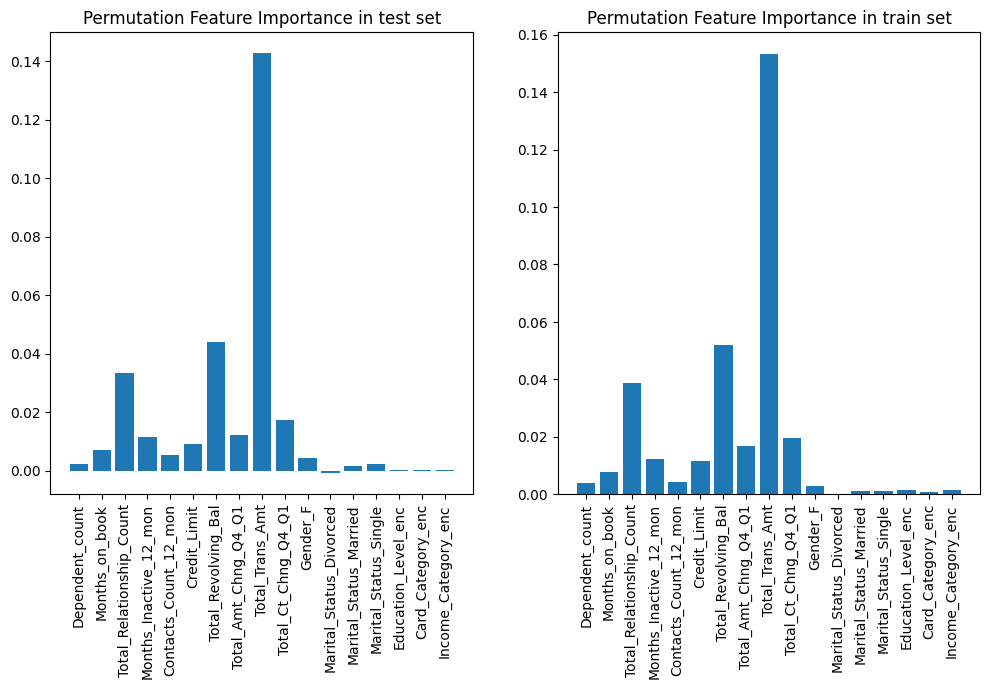

In [764]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(range(x_test_enc.shape[1]), perm_imp_test.importances_mean)
plt.xticks(range(x_test_enc.shape[1]), x_test_enc.columns, rotation=90)
plt.title("Permutation Feature Importance in test set")

plt.subplot(1, 2, 2)
plt.bar(range(x_train_enc.shape[1]), perm_imp_train.importances_mean)
plt.xticks(range(x_train_enc.shape[1]), x_train_enc.columns, rotation=90)
plt.title("Permutation Feature Importance in train set")

# plt.savefig("/pictures/pre_feat_imp2_depth_5.png", dpi=300, bbox_inches='tight')  # high quality

plt.show()

In [765]:
# Removing the 6 least important features
x_train_enc.drop(columns=["Marital_Status_Single", "Marital_Status_Married", "Marital_Status_Divorced", "Education_Level_enc", "Card_Category_enc", "Income_Category_enc"], inplace=True)
x_test_enc.drop(columns=["Marital_Status_Single", "Marital_Status_Married", "Marital_Status_Divorced", "Education_Level_enc", "Card_Category_enc", "Income_Category_enc"], inplace=True)

In [766]:
pipe.fit(x_train_enc, y_train)
y_pred = pipe.predict(x_test_enc)

In [767]:
print(f"Train accuracy: {pipe.score(x_train_enc, y_train)}")
print(f"Test accuracy: {pipe.score(x_test_enc, y_test)}")

report = classification_report(y_true=y_test, y_pred=y_pred)
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
print(report)

Train accuracy: 0.9593877299098876
Test accuracy: 0.9323790720631787
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1701
           1       0.77      0.83      0.80       325

    accuracy                           0.93      2026
   macro avg       0.87      0.89      0.88      2026
weighted avg       0.93      0.93      0.93      2026



In [768]:
perm_imp_train2 = permutation_importance(pipe, x_train_enc, y_train, n_repeats=10, random_state=seed)

for i, feature in enumerate(x_train_enc.columns):
  print(f"- {feature} => Mean: {perm_imp_train2.importances_mean[i]:.4f} ; Std: {perm_imp_train2.importances_std[i]:.4f}")

- Dependent_count => Mean: 0.0027 ; Std: 0.0006
- Months_on_book => Mean: 0.0079 ; Std: 0.0007
- Total_Relationship_Count => Mean: 0.0375 ; Std: 0.0022
- Months_Inactive_12_mon => Mean: 0.0132 ; Std: 0.0015
- Contacts_Count_12_mon => Mean: 0.0043 ; Std: 0.0008
- Credit_Limit => Mean: 0.0130 ; Std: 0.0010
- Total_Revolving_Bal => Mean: 0.0482 ; Std: 0.0016
- Total_Amt_Chng_Q4_Q1 => Mean: 0.0182 ; Std: 0.0015
- Total_Trans_Amt => Mean: 0.1546 ; Std: 0.0041
- Total_Ct_Chng_Q4_Q1 => Mean: 0.0187 ; Std: 0.0012
- Gender_F => Mean: 0.0024 ; Std: 0.0007


In [769]:
perm_imp_test2 = permutation_importance(pipe, x_test_enc, y_test, n_repeats=10, random_state=seed)

for i, feature in enumerate(x_test_enc.columns):
  print(f"- {feature} => Mean: {perm_imp_test2.importances_mean[i]:.4f} ; Std: {perm_imp_test2.importances_std[i]:.4f}")

- Dependent_count => Mean: 0.0026 ; Std: 0.0011
- Months_on_book => Mean: 0.0087 ; Std: 0.0012
- Total_Relationship_Count => Mean: 0.0280 ; Std: 0.0027
- Months_Inactive_12_mon => Mean: 0.0107 ; Std: 0.0032
- Contacts_Count_12_mon => Mean: 0.0024 ; Std: 0.0019
- Credit_Limit => Mean: 0.0089 ; Std: 0.0023
- Total_Revolving_Bal => Mean: 0.0406 ; Std: 0.0043
- Total_Amt_Chng_Q4_Q1 => Mean: 0.0110 ; Std: 0.0016
- Total_Trans_Amt => Mean: 0.1423 ; Std: 0.0073
- Total_Ct_Chng_Q4_Q1 => Mean: 0.0151 ; Std: 0.0034
- Gender_F => Mean: 0.0024 ; Std: 0.0010


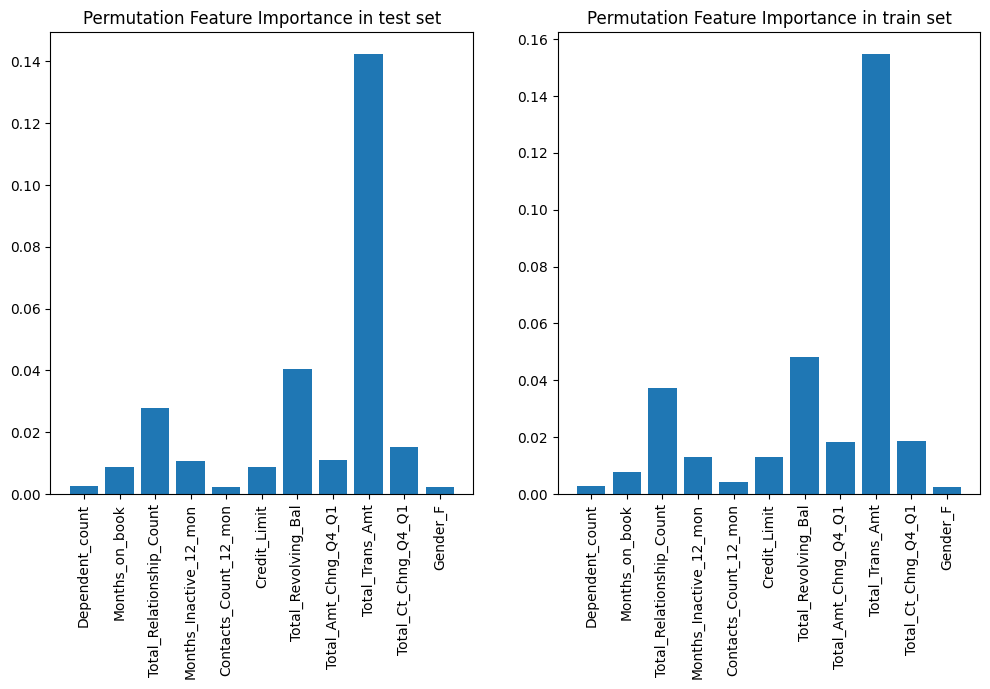

In [770]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(range(x_test_enc.shape[1]), perm_imp_test2.importances_mean)
plt.xticks(range(x_test_enc.shape[1]), x_test_enc.columns, rotation=90)
plt.title("Permutation Feature Importance in test set")

plt.subplot(1, 2, 2)
plt.bar(range(x_train_enc.shape[1]), perm_imp_train2.importances_mean)
plt.xticks(range(x_train_enc.shape[1]), x_train_enc.columns, rotation=90)
plt.title("Permutation Feature Importance in train set")

# plt.savefig("/pictures/pre_feat_imp2_depth_5.png", dpi=300, bbox_inches='tight')  # high quality

plt.show()

# Ranking

In [771]:
probs = pipe.predict_proba(x_test_enc)[:, 1]

In [772]:
ranking = probs.argsort()[::-1]
print(ranking)

[ 739 1267 1278 ... 1252  679 1952]


In [773]:
# Rank x and y accordingly
x_test_ranked = x_test.iloc[ranking].reset_index(drop=True)
y_test_ranked = y_test.iloc[ranking].reset_index(drop=True)
probs_ranked = probs[ranking]

In [ ]:
# Select top 5
k = 25

x_topk = x_test_ranked.iloc[:k]
y_topk = y_test_ranked.iloc[:k]
probs_topk = probs_ranked[:k]

In [775]:
topk_df = x_topk.copy()
topk_df['true_label'] = y_topk
topk_df['pred_prob'] = probs_topk

topk_df.head(25)

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,true_label,pred_prob
0,34,F,2,Graduate,Single,Less than $40K,Blue,36,1,2,...,1666.0,0,1666.0,0.713,2312,35,0.250,0.000,1,0.992555
1,56,F,3,Unknown,Single,Less than $40K,Blue,39,1,3,...,1632.0,0,1632.0,0.621,2509,47,0.424,0.000,1,0.992134
2,55,F,2,Graduate,Divorced,Less than $40K,Blue,50,2,6,...,1720.0,0,1720.0,0.707,2719,36,0.440,0.000,1,0.991797
3,45,F,2,College,Single,Less than $40K,Blue,33,1,3,...,1833.0,0,1833.0,0.549,2037,31,0.292,0.000,1,0.991093
4,44,F,1,High School,Single,Less than $40K,Blue,36,2,3,...,1895.0,0,1895.0,0.736,2472,40,0.429,0.000,1,0.989815
5,46,F,4,Doctorate,Single,Less than $40K,Blue,36,2,2,...,2292.0,0,2292.0,0.568,2595,31,0.409,0.000,1,0.988956
6,43,F,1,Graduate,Single,Less than $40K,Blue,36,2,3,...,2886.0,0,2886.0,0.587,2326,50,0.429,0.000,1,0.987914
7,50,F,1,College,Married,Unknown,Blue,37,2,2,...,1461.0,0,1461.0,0.563,2176,40,0.379,0.000,1,0.987750
8,39,F,1,Graduate,Married,Less than $40K,Blue,36,1,2,...,1462.0,0,1462.0,0.393,1998,36,0.161,0.000,1,0.987678
9,43,M,5,Graduate,Married,$60K - $80K,Blue,38,2,3,...,1438.3,0,1438.3,0.713,2389,49,0.361,0.000,1,0.983673


# SHAP

In [776]:
# id_instance_1 = 1
# id_instance_2 = 24
# class_instance = 1

# sample = x_test_enc
# masker = shap.maskers.Independent(data=x_test_enc)

# explainer = shap.Explainer(model=pipe["rf"].predict_proba, # the function predict_proba
#                            masker=masker)

# shap_values = explainer.shap_values(sample)

# shap_values_instance_1 = shap_values[id_instance_1][:, class_instance]
# shap_values_instance_2 = shap_values[id_instance_2][:, class_instance]
# print(shap_values_instance_1)
# print()
# print(shap_values_instance_2)

In [777]:
# shap_diff = np.subtract(shap_values_instance_1, shap_values_instance_2)
# val_diff = np.subtract(x_test_enc.iloc[1], x_test_enc.iloc[24])

# prod = shap_diff * val_diff

# sum = np.sum(prod)
# print(sum)